In [1]:
import warnings
warnings.filterwarnings('ignore')

# MDA

En base a los datos de oleaje de la boya de Bilbao ('Bilbao-Vizcaya Ext.mat'), se pide rellenar y contestar las siguientes preguntas

In [2]:
# basic
import os
import os.path as op
import sys

# common
import numpy as np
import pandas as pd
import xarray as xr
from scipy.io import loadmat

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

#mda
from mda import MaxDiss_Simplified_NoThreshold

#rbf
from scipy.interpolate import RBFInterpolator

## 1. Cargar Datos

In [3]:
p_db = op.join(os.getcwd(),'..','..','data','Buoys')

# database waves (mat file)
p_dat = op.join(p_db, 'Bilbao-Vizcaya Ext.mat')

# database exploration
data_mat = loadmat(p_dat)

array = data_mat[list(data_mat.keys())[-1]]

data = pd.DataFrame(
    {
        'year': array[:,0],
        'month': array[:,1],
        'day': array[:,2],
        'hour': array[:,3],
        'hs': array[:,4],
        'tp': array[:,6],
        'dir': array[:,9],
    }
)

data['dates'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
data = data.drop(['year', 'month', 'day', 'hour'], axis=1).set_index('dates')
data

,hs,tp,dir
dates,,,
1990-11-07 12:00:00,1.1,4.8,96.0
1990-11-07 15:00:00,1.1,5.4,98.0
1990-11-07 18:00:00,1.0,4.8,112.0
1990-11-07 21:00:00,1.2,4.7,100.0
1990-11-08 00:00:00,1.3,5.2,104.0
...,...,...,...
2009-07-19 01:00:00,1.9,7.4,309.0
2009-07-19 02:00:00,1.9,7.7,310.0
2009-07-19 03:00:00,1.8,7.7,309.0


## 2. Pintar las series temporales de las variables Hs, Tp y Dirección

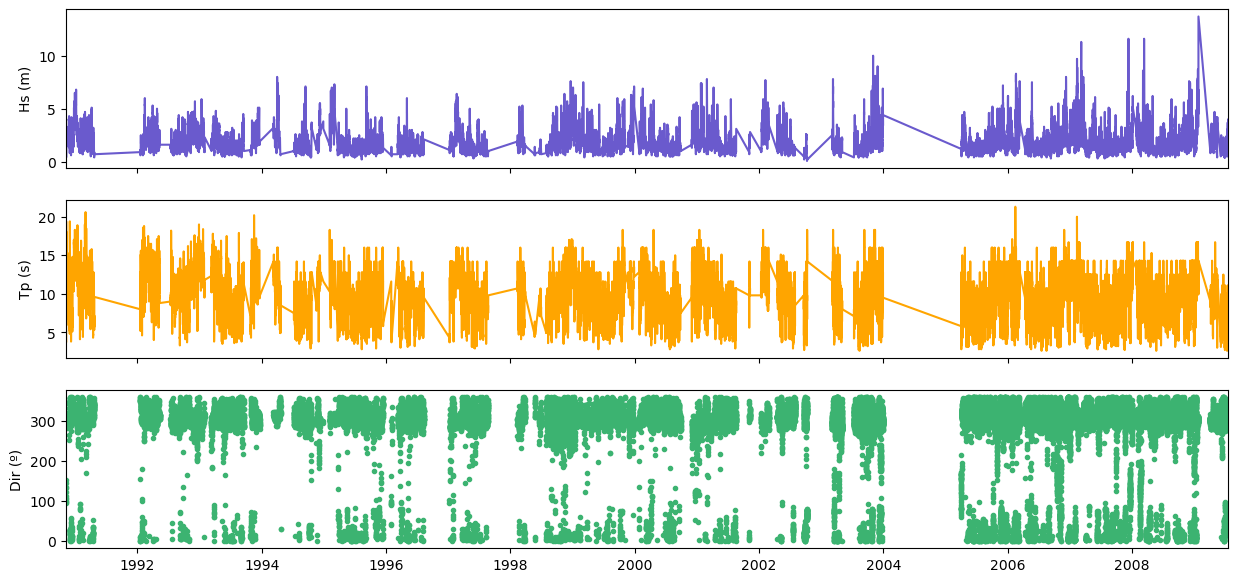

In [4]:
# temporal series of variables (Hs, Tp, Dir)
fig, axs = plt.subplots(3, figsize=(15, 7), sharex=True)
axs[0].plot(data.index, data.hs, c='slateblue')
axs[1].plot(data.index, data.tp, c='orange')
axs[2].plot(data.index, data.dir, '.', c='mediumseagreen')
axs[2].set_xlim(data.index.values[0], data.index.values[-1])

axs[0].set_ylabel('Hs (m)')
axs[1].set_ylabel('Tp (s)')
axs[2].set_ylabel('Dir (º)')

plt.show()

## 3. Pintar scatter plots de las variables Hs, Tp y Direccion

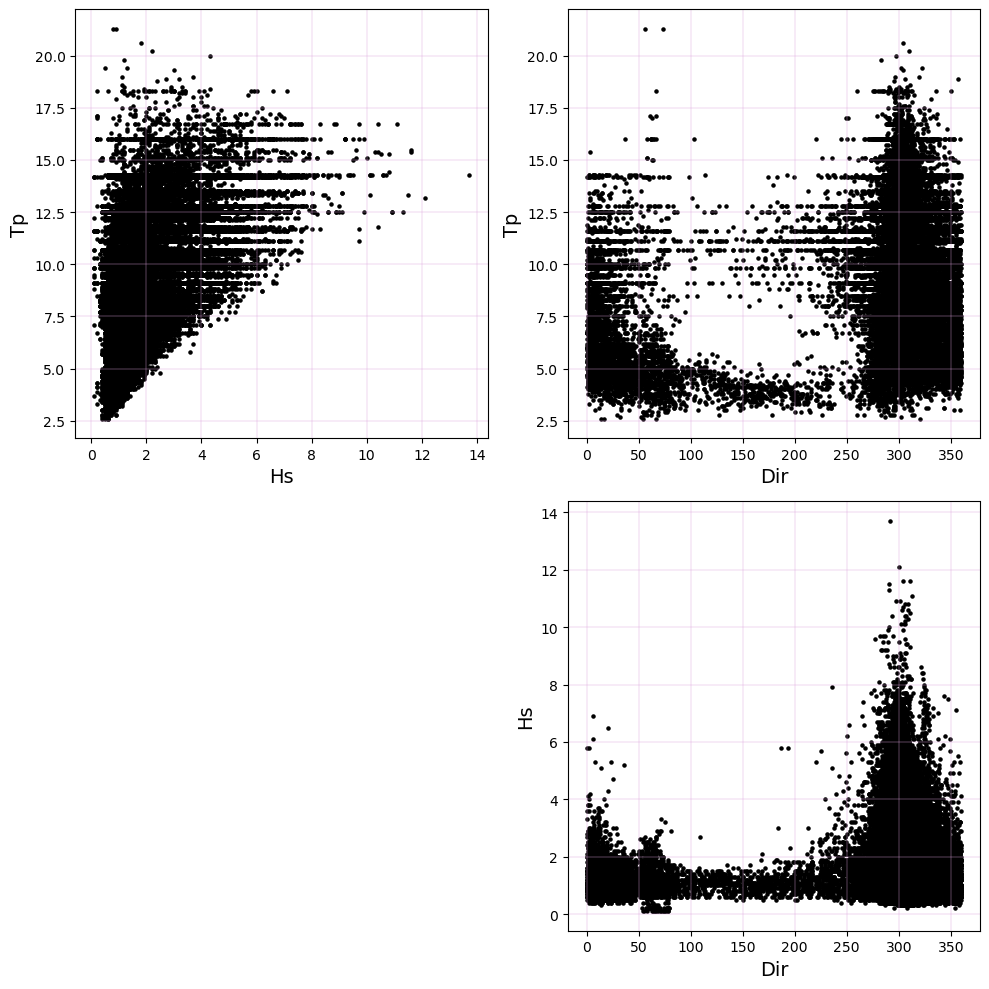

In [5]:
v1, v1_l = data.hs.values, 'Hs'
v2, v2_l = data.tp.values, 'Tp'
v3, v3_l = data.dir.values, 'Dir'
size_point = 5

fig = plt.figure(figsize = [10, 10], tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0,0])
ax.scatter(v1,v2,c='k', s=size_point)
ax.set_xlabel(v1_l, fontsize = 14); ax.set_ylabel(v2_l, fontsize = 14)
ax.grid(':', color = 'plum', linewidth=.3)

ax1 = fig.add_subplot(gs[0,1])
ax1.scatter(v3,v2,c='k', s=size_point)
ax1.set_xlabel(v3_l, fontsize = 14); ax1.set_ylabel(v2_l, fontsize = 14)
ax1.grid(':', color = 'plum', linewidth=.3)


ax2 = fig.add_subplot(gs[1,1])
ax2.scatter(v3,v1,c='k', s=size_point)
ax2.set_xlabel(v3_l, fontsize = 14); ax2.set_ylabel(v1_l, fontsize = 14)
ax2.grid(':', color = 'plum', linewidth=.3)


## 4. Seleccionar 200 puntos de las variables [Hs, Tp y Dir] mediante MDA

In [6]:
# subset size, scalar and directional indexes
n_subset = 200           # subset size
ix_scalar = [0, 1]        # x,y,z
ix_directional = [2]      # 

In [7]:
matrix_mda = np.vstack([data.hs.values,data.tp.values,data.dir.values]).T
matrix_mda.shape #[Number of points] x [Number of dimensions]

(59119, 3)

In [8]:
# MDA algorithm
sel = MaxDiss_Simplified_NoThreshold(matrix_mda, n_subset, ix_scalar, ix_directional)


MaxDiss waves parameters: 59119 --> 200



## 5. Pintar histograma de la población total de datos y los 200 puntos seleccionados con MDA

- Superponer los 2 histogramas para poder comparar.
- Es necesario para poder comparar activar density = True, en la function hist de matplotlib. 

Text(0.5, 0, 'Dir')

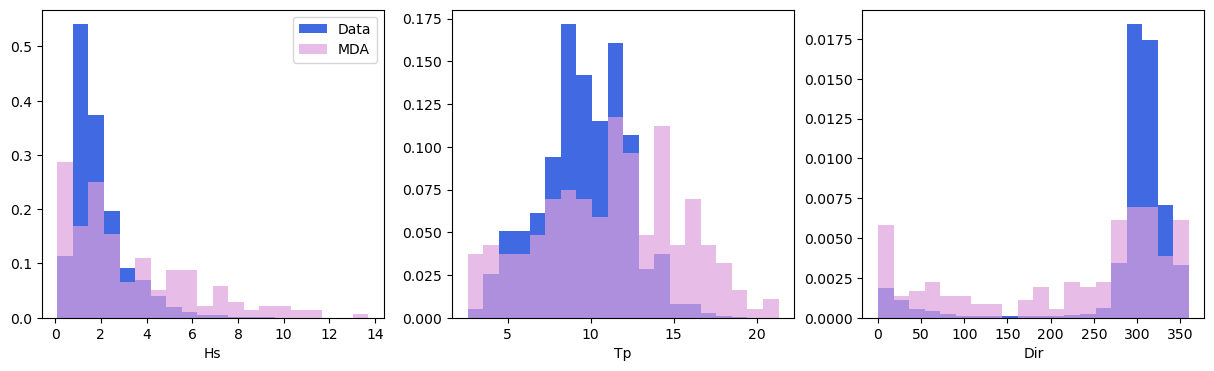

In [9]:
fig, axs = plt.subplots(1,3, figsize=(15, 4))

axs[0].hist(data.hs.values, density = True, bins = 20, color = 'royalblue', label = 'Data');
axs[0].hist(sel[:,0], density = True, bins = 20, alpha=.7, color = 'plum', label = 'MDA');
axs[0].set_xlabel('Hs')
axs[0].legend()

axs[1].hist(data.tp.values, density = True, bins = 20, color = 'royalblue');
axs[1].hist(sel[:,1], density = True, bins = 20, alpha=.7, color = 'plum');
axs[1].set_xlabel('Tp')

axs[2].hist(data.dir.values, density = True, bins = 20, color = 'royalblue');
axs[2].hist(sel[:,2], density = True, bins = 20, alpha=.7, color = 'plum');
axs[2].set_xlabel('Dir')

## 6. Pintar scatter de los puntos seleccionado sobre la población de datos

- Repetir la figura del punto 3. superponiendo los 200 puntos seleccionados con MDA

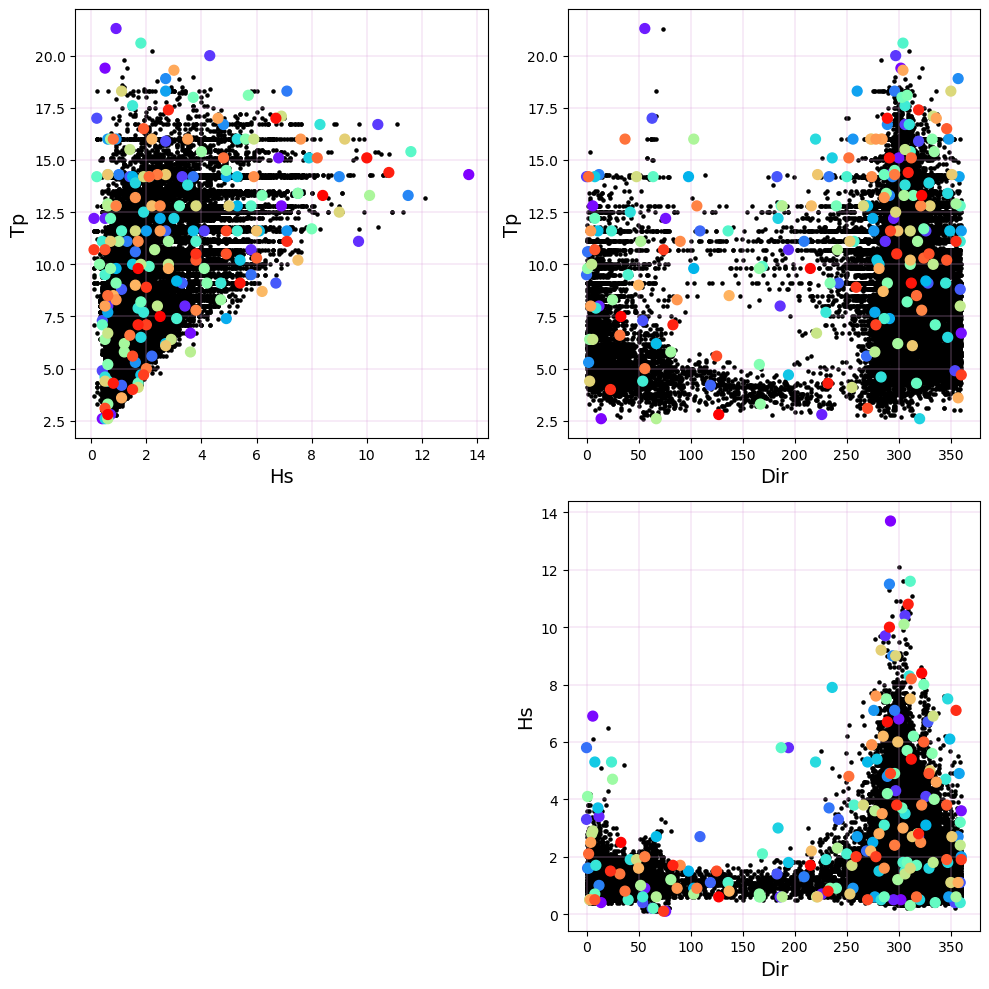

In [10]:
v1, v1_l = data.hs.values, 'Hs'
v2, v2_l = data.tp.values, 'Tp'
v3, v3_l = data.dir.values, 'Dir'
size_point = 5

fig = plt.figure(figsize = [10, 10], tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0,0])
ax.scatter(v1,v2,c='k', s=size_point)
ax.set_xlabel(v1_l, fontsize = 14); ax.set_ylabel(v2_l, fontsize = 14)
ax.grid(':', color = 'plum', linewidth=.3)

ax1 = fig.add_subplot(gs[0,1])
ax1.scatter(v3,v2,c='k', s=size_point)
ax1.set_xlabel(v3_l, fontsize = 14); ax1.set_ylabel(v2_l, fontsize = 14)
ax1.grid(':', color = 'plum', linewidth=.3)

ax2 = fig.add_subplot(gs[1,1])
ax2.scatter(v3,v1,c='k', s=size_point)
ax2.set_xlabel(v3_l, fontsize = 14); ax2.set_ylabel(v1_l, fontsize = 14)
ax2.grid(':', color = 'plum', linewidth=.3)

# Selected points
ax.scatter(sel[:,0], sel[:,1], s=50, c=range(len(sel)), alpha=1, zorder=2, cmap='rainbow')
ax1.scatter(sel[:,2], sel[:,1], s=50, c=range(len(sel)), alpha=1, zorder=2, cmap='rainbow')
im = ax2.scatter(sel[:,2], sel[:,0], s=50, c=range(len(sel)), alpha=1, zorder=2, cmap='rainbow')


# Uso de MDA + RBF

El flujo de Energia FE, depende de las variables Hs y Tp, y se calcula de la siguiente forma: FE = Hs^2 * Tp

## 7. Pintar la superficie del FE para todos los datos en 2D

El flujo de energia, FE, depende unicamente de las variables Hs y , FE= Hs^2 * Tp

In [11]:
FE = data.hs.values**2 * data.tp.values

Text(0, 0.5, 'Tp')

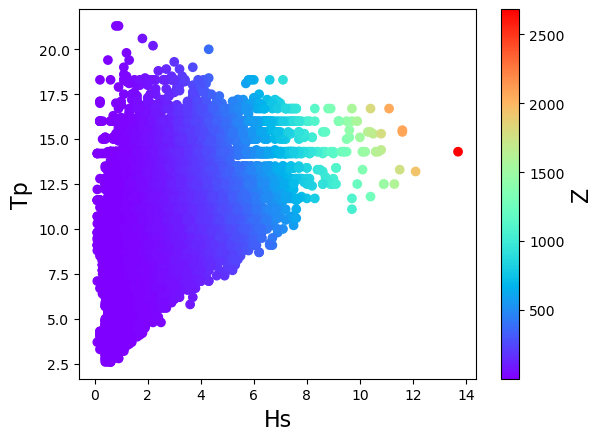

In [12]:
fig, ax = plt.subplots()
im = ax.scatter(data.hs.values,data.tp.values, c = FE, vmin = FE.min(), vmax = FE.max(), cmap = 'rainbow')

plt.colorbar(im).set_label('Z', fontsize = 16)
plt.xlabel('Hs', fontsize = 16)
plt.ylabel('Tp', fontsize = 16)

## 8. Seleccionar 50 puntos

In [13]:
# subset size, scalar and directional indexes
n_subset = 50           # subset size
ix_scalar = [0, 1]        # x,y,z
ix_directional = []      # 

In [14]:
matrix_mda = np.vstack([data.hs.values,data.tp.values]).T
matrix_mda.shape #[Number of points] x [Number of dimensions]

(59119, 2)

In [15]:
# MDA algorithm
sel2 = MaxDiss_Simplified_NoThreshold(matrix_mda, n_subset, ix_scalar, ix_directional)


MaxDiss waves parameters: 59119 --> 50



## 9. Calcular el FE para los puntos seleccionados

In [16]:
FE_sel = sel2[:,0]**2 * sel2[:,1]

## 10. Pintar los 50 puntos superpuestos a la superficie

Text(0, 0.5, 'Tp')

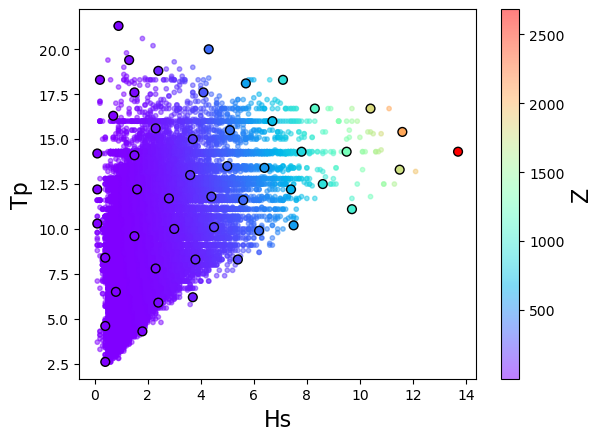

In [17]:
fig, ax = plt.subplots()
im = ax.scatter(data.hs.values,data.tp.values, s=10, c = FE, vmin = FE.min(), vmax = FE.max(), cmap = 'rainbow', alpha=.5)

ax.scatter(sel2[:,0], sel2[:,1], c = FE_sel, s=40, vmin = FE.min(), vmax = FE.max(), cmap = 'rainbow', edgecolor = 'black')


plt.colorbar(im).set_label('Z', fontsize = 16)
plt.xlabel('Hs', fontsize = 16)
plt.ylabel('Tp', fontsize = 16)

## 11. Hacer el FIT de la RBF para los 50 puntos seleccionados

In [18]:
rbf_func = RBFInterpolator(np.vstack((sel2[:,0], sel2[:,1])).T, FE_sel)  # radial basis function interpolator instance

## 12. Interpolar a la población completa de [Hs, Tp]

In [19]:
results = rbf_func(np.vstack((data.hs.values, data.tp.values)).T)

## 13. Pintar el scatter plot de [Hs, Tp] donde el color seran los errores

- El error será la diferencia entre los valores reales del flujo de energía y los calculados mediante la RBF

Text(0, 0.5, 'Tp')

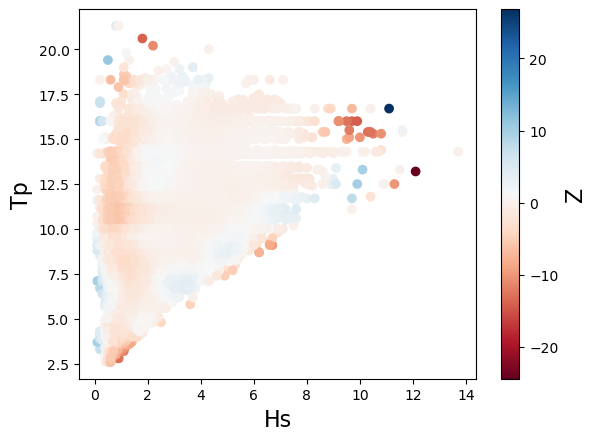

In [20]:
fig, ax = plt.subplots()
im = ax.scatter(data.hs.values,data.tp.values, c = FE - results, cmap = 'RdBu')

plt.colorbar(im).set_label('Z', fontsize = 16)
plt.xlabel('Hs', fontsize = 16)
plt.ylabel('Tp', fontsize = 16)

## 14. Calcular el Error Medio Cuadrático

$$\textbf{RMSE =  } sqrt(\frac{\sum(RBF_{model} - Real)^2}{n})$$


In [22]:
RMSE = np.sqrt(np.mean((FE - results)**2))
RMSE

2.2577041745990623

## 15. Calcular el Numero de Puntos Optimo a seleccionar con MDA

- Seleccionar 50 valores entre 50 y 500

In [22]:
disc = np.arange(50, 550, 50)

In [23]:
RMSE = []

for d in disc:
    
    #En cada loop del bucle for hay que cambiar el n_subset
    n_subset = d           # subset size
    
    # MDA algorithm
    sel2 = MaxDiss_Simplified_NoThreshold(matrix_mda, n_subset, ix_scalar, ix_directional)
    
    #Calcular FE
    FE_sel = sel2[:,0]**2 * sel2[:,1]

    #RBF
    rbf_func = RBFInterpolator(np.vstack((sel2[:,0], sel2[:,1])).T, FE_sel)  # radial basis function interpolator instance
    
    #Interpolar
    results = rbf_func(np.vstack((data.hs.values, data.tp.values)).T)
    
    RMSE.append(np.sqrt(np.mean((FE - results)**2)))
    


MaxDiss waves parameters: 59119 --> 50

   MDA centroids: 50/50
MaxDiss waves parameters: 59119 --> 100

   MDA centroids: 100/100
MaxDiss waves parameters: 59119 --> 150

   MDA centroids: 150/150
MaxDiss waves parameters: 59119 --> 200

   MDA centroids: 200/200
MaxDiss waves parameters: 59119 --> 250

   MDA centroids: 250/250
MaxDiss waves parameters: 59119 --> 300

   MDA centroids: 300/300
MaxDiss waves parameters: 59119 --> 350

   MDA centroids: 350/350
MaxDiss waves parameters: 59119 --> 400

   MDA centroids: 400/400
MaxDiss waves parameters: 59119 --> 450

   MDA centroids: 450/450
MaxDiss waves parameters: 59119 --> 500



Text(0, 0.5, 'RMSE')

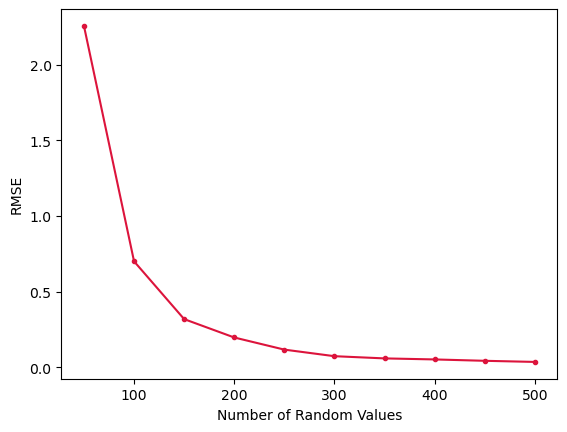

In [24]:
plt.plot(disc, RMSE, '.-' ,color = 'crimson')
plt.xlabel('Number of Random Values')
plt.ylabel('RMSE')